In [24]:
# 🔧 Step 1: Install necessary packages
!pip install pandas scikit-learn nltk pymupdf matplotlib
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# 📁 Step 2: Upload files (CSV and Resume PDF)
from google.colab import files

print("📤 Upload your CSV dataset and your resume PDF:")
uploaded = files.upload()


📤 Upload your CSV dataset and your resume PDF:


Saving my_resume.pdf to my_resume (1).pdf


In [26]:
# 📄 Step 3: Load and clean the dataset
import pandas as pd
import re

df = pd.read_csv('Business_analyst_job_listings_linkedin.csv')

# Only keep rows with title and description
df = df.dropna(subset=['title', 'description'])

# Combine title + description
df['text'] = (df['title'] + '. ' + df['description']).str.lower()

# Clean text
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def clean(text):
    text = re.sub(r'[^a-z0-9\s]', ' ', text.lower())
    return ' '.join(word for word in text.split() if word not in stop)

df['clean'] = df['text'].apply(clean)

df[['title', 'clean']].head()


,title,clean
0,Business Analyst,business analyst company wipro limited nyse wi...
1,"Business Analyst, CS Workforce Management",business analyst cs workforce management netfl...
2,Business Analyst,business analyst required fields number positi...
3,Business Analyst,business analyst job id 7930 location miami fl...
4,Business Analyst,business analyst salary 130 000 00 partnered f...


In [27]:
# 🔠 Step 4: TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.7, min_df=5, ngram_range=(1,2))
job_vecs = tfidf.fit_transform(df['clean'])

print(f"✅ Vectorized {job_vecs.shape[0]} job postings")


✅ Vectorized 921 job postings


In [28]:
# 📄 Step 5: Extract and clean resume text from uploaded PDF
import fitz  # PyMuPDF

resume_filename = next(name for name in uploaded if name.endswith('.pdf'))

doc = fitz.open(resume_filename)
resume_text = ''
for page in doc:
    resume_text += page.get_text()

resume_clean = clean(resume_text)
resume_vec = tfidf.transform([resume_clean])

print("📑 Resume uploaded and processed successfully!")


📑 Resume uploaded and processed successfully!


In [29]:
# 🤖 Step 6: Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

similarities = cosine_similarity(resume_vec, job_vecs).flatten()
top_n = similarities.argsort()[-5:][::-1]

# Show top job matches
print("🔍 Top 5 Matching Jobs:\n")
for i, idx in enumerate(top_n):
    print(f"{i+1}. 🏷️ {df.iloc[idx]['title']}")
    print(f"   📄 {df.iloc[idx]['description'][:300]}...\n")


🔍 Top 5 Matching Jobs:

1. 🏷️ AI Business Analyst
   📄 Job Title: Sr. AI Business Analyst

Location: Prefer NY, but remote ok in EST time zone

Job Description

We are seeking a highly experienced AI Business Analyst to analyse and write business requirement document (BRD) to help PayPal build a centralized Enterprise AI Risk Management System (“System”...

2. 🏷️ Business Analyst
   📄 Job Title: Business Analyst

Location: National Harbor, MD (Hybrid)

Type: Full Time

Compensation: $80,000 to $110,000 DOE, Annually




Eager to work at the intersection of business and bleeding-edge technology? Join a team that’s all in on bringing next-generation AI capabilities to the most nota...

3. 🏷️ Business Analyst (Plano, Texas) (REMOTE) (CONTRACT)
   📄 Description

This is a Senior Business Analyst opportunity, in the United States, on the Analytics Enablement Consulting team, at Client for candidates who are authorized to work in the United States without restriction.

The Client Senior Busi

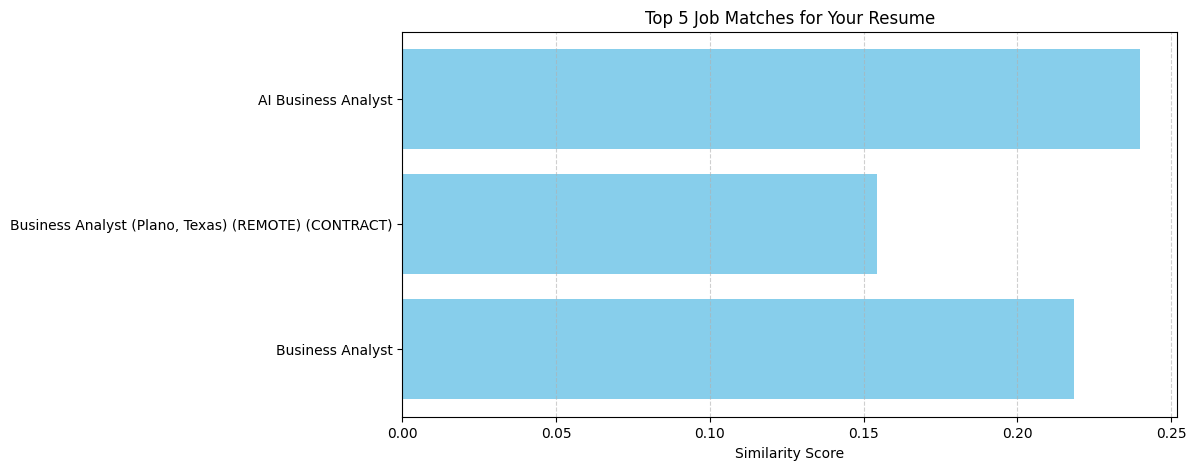

In [30]:
# 📊 Step 7: Plot similarity scores
import matplotlib.pyplot as plt

top_scores = similarities[top_n]
top_titles = [df.iloc[i]['title'] for i in top_n]

plt.figure(figsize=(10,5))
bars = plt.barh(top_titles[::-1], top_scores[::-1], color='skyblue')
plt.xlabel("Similarity Score")
plt.title("Top 5 Job Matches for Your Resume")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import pandas as pd

# Load and preprocess your data
df = pd.read_csv("Business_analyst_job_listings_linkedin.csv")
df['clean'] = df['description'].astype(str).str.lower()  # simplify cleaning for now

tfidf = TfidfVectorizer(max_df=0.8, min_df=5)
tfidf_matrix = tfidf.fit_transform(df['clean'])

# Save model again using same sklearn version as your app
with open("model.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save cleaned jobs
df.to_csv("jobs.csv", index=False)

